Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
DateCrawled — дата скачивания анкеты из базы
VehicleType — тип автомобильного кузова
RegistrationYear — год регистрации автомобиля
Gearbox — тип коробки передач
Power — мощность (л. с.)
Model — модель автомобиля
Kilometer — пробег (км)
RegistrationMonth — месяц регистрации автомобиля
FuelType — тип топлива
Brand — марка автомобиля
NotRepaired — была машина в ремонте или нет
DateCreated — дата создания анкеты
NumberOfPictures — количество фотографий автомобиля
PostalCode — почтовый индекс владельца анкеты (пользователя)
LastSeen — дата последней активности пользователя
Целевой признак
Price — цена (евро)

# 1. Подготовка данных

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Дропаем те столбцы, которые не будут представлять интереса для машинного обучения. Подтвердим наши догадки фактами:

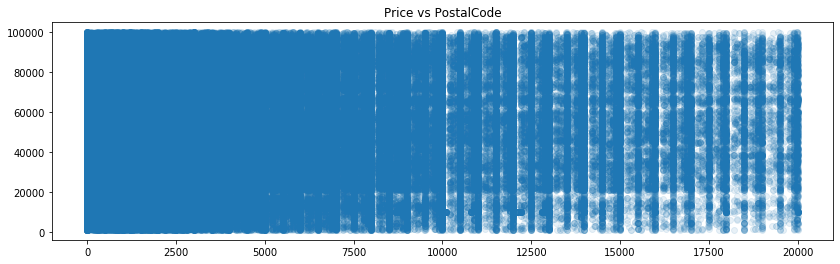

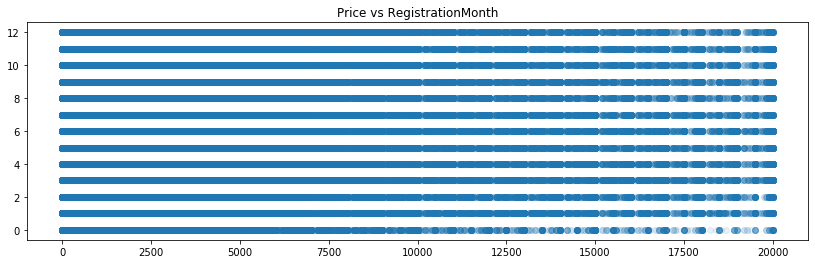

In [6]:
plt.figure(figsize=(14,4))
plt.scatter(df['Price'], df['PostalCode'], alpha=0.1)
plt.title('Price vs PostalCode')
plt.show()

plt.figure(figsize=(14,4))
plt.scatter(df['Price'], df['RegistrationMonth'], alpha=0.1)
plt.title('Price vs RegistrationMonth')
plt.show()


Так как распределения нормальные, то можем сделать вывод, что зависимости между месяцем регистрации, почтовым индексом и ценой машин - нет. Поэтому - удаляем столбцы.

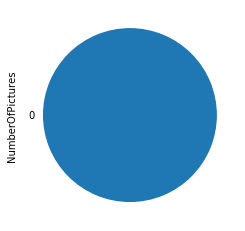

In [7]:
column = 'NumberOfPictures'
df[column].value_counts().plot(kind='pie')
plt.show()
df.drop(columns=column, inplace=True)

По фото ещё проще - их просто нет. Поэтому удаляем этот столбец - он вряд ли будет нести ценную информацию для будущей модели. 

Смотрим, что с годами.

In [8]:
np.sort(df['RegistrationYear'].unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Принимаем решение избавиться от явных ошибок (1000, 9996 и так далее) и установить предельный год на отметке в 1970 году. Почему не ниже? Если брать годовую планку ниже, то выходит, что мы мешаем рынок б/у машин с рынком олдтаймеров, представляющим коллекционную ценность и ценник сильно выше рядовых машин. Конечно, среди выбранного периода от 1970 года будут попадаться и примеры янгтаймеров, однако, на то они и янг, что их цена еще не такая высокая как у олдовых. Наверно, в идеале, сервису стоит сделать отдельную вкладку по поиску именно коллекционных вещей. 

In [9]:
invalid_year = df[(df.RegistrationYear < 1970) | (df.RegistrationYear > 2019)]
invalid_year

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,24148,2016-03-19 08:46:47
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,44628,2016-03-20 16:44:37
630,2016-03-18 12:43:41,12000,sedan,1969,manual,140,s_klasse,80000,3,petrol,mercedes_benz,no,2016-03-18 00:00:00,46286,2016-04-05 22:16:44
1794,2016-04-03 21:49:57,12800,coupe,1965,manual,90,other,100000,8,petrol,ford,no,2016-04-03 00:00:00,12049,2016-04-05 23:15:21
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25 00:00:00,58135,2016-03-25 15:58:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353447,2016-03-27 00:46:19,2900,small,1969,manual,18,500,5000,8,petrol,fiat,no,2016-03-26 00:00:00,74076,2016-03-28 17:45:04
353531,2016-03-16 21:56:55,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,NaN,2016-03-16 00:00:00,23936,2016-03-30 18:47:41
353961,2016-03-17 13:54:22,200,NaN,1910,NaN,0,NaN,5000,0,petrol,sonstige_autos,NaN,2016-03-17 00:00:00,42289,2016-03-31 22:46:47
354037,2016-03-23 16:57:30,10500,convertible,1968,manual,54,other,20000,4,NaN,renault,no,2016-03-23 00:00:00,63755,2016-03-25 00:47:18


In [10]:
df.drop(invalid_year.index, inplace=True)

Смотрим, что с мощностью.

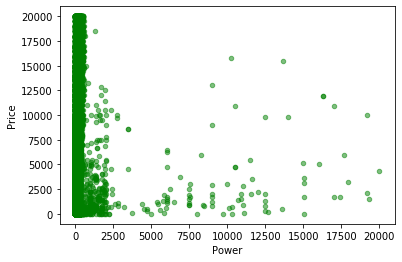

In [11]:
data = pd.concat([df['Price'], df['Power']], axis = 1)
data.plot.scatter(x ='Power', y= 'Price', c= 'green', alpha = 0.5);

Видим сильную корреляцию между ценой и мощностью (капитан очевидность). Разберемся, что там с аномальными знацениями. Самым мощным автомобилем является некий Devel Sixteen Engine Dyno (https://fastmb.ru/autonews/autonews_mir/1079-top-10-samyh-moschnyh-legkovyh-avtomobiley-harakteristiki-foto-video.html) с показателем в 4 515 лошадиных сил. В какой-то мере такой показатель - тоже аномалия, допустим Макларен показывает мощность в 1600 лошадиных сил и это больше похоже на нормальное максимальное значение для рядовых гражданских машин, не входящих в программу-выставку автомобилей в Эмиратах. Поэтому - избавляемся от строк, где показатель мощности выше 1600.

In [12]:
print(df.query('Power > 1600')['Power'].count())
df.query('Power > 1600')

174


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
2102,2016-03-21 11:55:22,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes,2016-03-21 00:00:00,1723,2016-04-04 04:49:06
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02 00:00:00,65830,2016-04-06 11:46:49
9664,2016-03-14 20:06:19,2599,NaN,2016,manual,1779,zafira,150000,0,petrol,opel,no,2016-03-14 00:00:00,60326,2016-04-07 09:45:27
9875,2016-03-31 20:51:13,550,wagon,2003,manual,1753,focus,150000,1,gasoline,ford,yes,2016-03-31 00:00:00,21039,2016-03-31 20:51:13
11039,2016-03-25 19:55:32,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no,2016-03-25 00:00:00,57520,2016-04-01 19:16:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348006,2016-03-22 13:44:40,355,sedan,1998,manual,1799,vectra,150000,6,petrol,opel,NaN,2016-03-22 00:00:00,39175,2016-03-29 16:45:09
348137,2016-03-16 21:48:39,850,sedan,1993,auto,9012,golf,150000,0,petrol,volkswagen,NaN,2016-03-16 00:00:00,14482,2016-04-03 09:17:43
348237,2016-04-04 12:38:11,3000,coupe,2007,manual,2007,corsa,150000,3,gasoline,opel,yes,2016-04-04 00:00:00,72218,2016-04-04 12:38:11
348668,2016-03-05 17:53:09,1000,wagon,1996,manual,2598,a6,150000,7,NaN,audi,NaN,2016-03-05 00:00:00,7646,2016-03-07 16:17:01


In [13]:
df = df.query('Power < 1600')

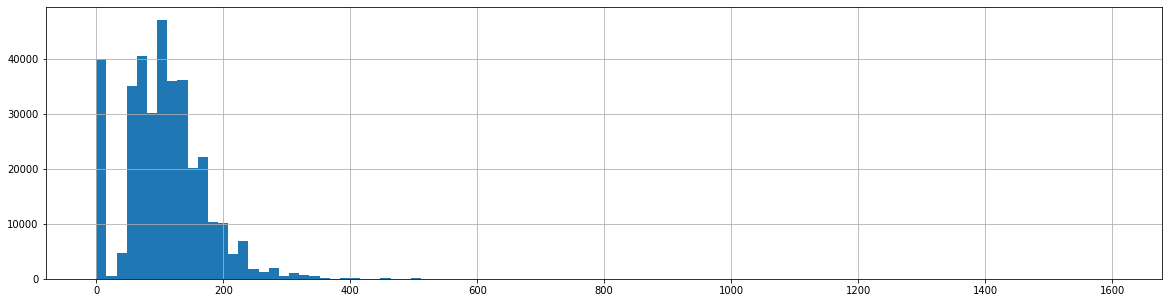

In [14]:
df['Power'].hist(bins=100, figsize=(20,5));

In [15]:
df = df.query('Power < 400')

Что делать с показателями мощности в 0 единиц - не совсем понятно. Это реальные данные, которые были заполнены пользователями, то есть, естественные ошибки, которые будут происходить и в дальнейшем. Поэтому стоит представлять такую модель, которая работала с реальными данными - очищенными, но не выхолощенными до пустоты. В общем, стоит работать с неидеальной действительностью и иметь в итоге реальные результаты, чем со сферическим конем в вакууме и красивыми, но бесполезными для практики результатами. Поехали теперь разбираться с показателем цены.

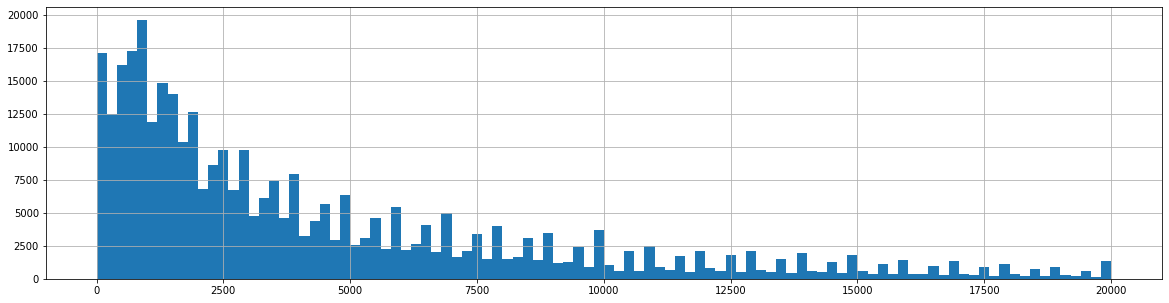

In [16]:
df['Price'].hist(bins=100, figsize=(20,5));

Также видим, что есть очень много нулевых значений, рассмотрим их поближе.

In [17]:
print(df.query('Price < 10 ')['Price'].count())

11769


In [18]:
print(df.query('Price < 5 ')['Price'].count())

11724


In [19]:
print(df.query('Price < 20 ')['Price'].count())

11913


In [20]:
print(df.query('Price == 0 ')['Price'].count())

10553


Таки принимаем решение оставить те столбцы, у которых цена выше 0, остальные - удаляем. Почему там вышли нули, и почему в заполнении анкеты не стоит блок на установку цены в 0 единиц - другой вопрос. Возможно, стоит дать обратную связь по заполнению этого важного поля сервису по продаже автомобилей. 

In [21]:
df = df.loc[df.loc[:, 'Price'] > 0]

Поработаем с пропусками, которые есть в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired. Заменим NaN-ы нетипичным значением unk - модель воспримет их как отдельную категорию.

In [22]:
df.fillna(value='unk', inplace=True)
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unk,1993,manual,0,golf,150000,0,petrol,volkswagen,unk,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unk,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unk,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21


In [23]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'], axis='columns')

# 2. Обучение моделей

Преобразуем категориальные признаки в численные:

In [25]:
df_ohe = pd.get_dummies(df, drop_first=True)

Признаки для обучения модели линейной регрессии:

In [26]:
features_lr = df_ohe.drop(['Price'], axis = 1)
target_lr = df_ohe['Price']

Преобразуем столбцы с категориальными признаки в тип данных category

In [27]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [28]:
for col in categorical:
    df[col] = df[col].astype('category')

Признаки для обучения моделей CBR и LGBM

In [29]:
features = df.drop(['Price'], axis = 1)
target = df['Price']

In [30]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr, target_lr, test_size=.25, random_state=12345)

In [31]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=12345)

In [32]:
#напишем формулу для получения значения метрики RMSE
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

# 3. Анализ моделей

### LinearRegression

In [33]:
lr_model = LinearRegression()

In [34]:
%%time
lr_model.fit(features_train_lr, target_train_lr)

CPU times: user 22.1 s, sys: 5.74 s, total: 27.8 s
Wall time: 27.9 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
%%time
predicted_lr = pd.Series(lr_model.predict(features_test_lr))

CPU times: user 106 ms, sys: 160 ms, total: 267 ms
Wall time: 292 ms


In [36]:
rmse(target_test_lr, predicted_lr)

2647.966135305653

### CatBoostRegressor

Поработаем с CBR и различными гиперпараметрами c помощью кросс-валидации

In [37]:
for iteration in range(10, 111, 25):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=10, verbose=10, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при iterations =", iteration, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

0:	learn: 4401.4961234	total: 421ms	remaining: 3.79s
9:	learn: 3683.9294682	total: 3.42s	remaining: 0us
0:	learn: 4391.8450815	total: 275ms	remaining: 2.47s
9:	learn: 3675.1851135	total: 3.27s	remaining: 0us
Score при iterations = 10 : [0.32845046 0.32802993]
Score mean = 0.32824019488988043

0:	learn: 4401.4961234	total: 270ms	remaining: 9.19s
10:	learn: 3619.0632292	total: 3.56s	remaining: 7.77s
20:	learn: 3089.8979690	total: 6.85s	remaining: 4.57s
30:	learn: 2723.4151454	total: 10.1s	remaining: 1.31s
34:	learn: 2613.6406407	total: 11.4s	remaining: 0us
0:	learn: 4391.8450815	total: 307ms	remaining: 10.5s
10:	learn: 3610.0451990	total: 3.61s	remaining: 7.87s
20:	learn: 3076.4371819	total: 6.89s	remaining: 4.59s
30:	learn: 2706.0220747	total: 10.1s	remaining: 1.3s
34:	learn: 2593.8465118	total: 11.4s	remaining: 0us
Score при iterations = 35 : [0.66156947 0.66274399]
Score mean = 0.6621567271266977

0:	learn: 4401.4961234	total: 243ms	remaining: 14.3s
10:	learn: 3619.0632292	total: 3.63

In [38]:
for depth in range(5, 16, 2):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=20, depth=depth, verbose=10, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при depth =", depth, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

0:	learn: 4415.6777893	total: 183ms	remaining: 3.47s
10:	learn: 3728.2302718	total: 2.08s	remaining: 1.7s
19:	learn: 3291.1076194	total: 3.77s	remaining: 0us
0:	learn: 4404.0263029	total: 196ms	remaining: 3.71s
10:	learn: 3715.1614892	total: 2.08s	remaining: 1.71s
19:	learn: 3280.0114489	total: 3.78s	remaining: 0us
Score при depth = 5 : [0.46522771 0.46434709]
Score mean = 0.464787396890342

0:	learn: 4406.4824574	total: 261ms	remaining: 4.95s
10:	learn: 3669.7347858	total: 2.67s	remaining: 2.18s
19:	learn: 3200.5469899	total: 4.85s	remaining: 0us
0:	learn: 4397.4377193	total: 208ms	remaining: 3.96s
10:	learn: 3657.6990595	total: 2.7s	remaining: 2.21s
19:	learn: 3185.7567419	total: 4.99s	remaining: 0us
Score при depth = 7 : [0.4940027  0.49443968]
Score mean = 0.4942211901705848

0:	learn: 4402.9481196	total: 301ms	remaining: 5.71s
10:	learn: 3633.9321469	total: 3.59s	remaining: 2.94s
19:	learn: 3151.0621733	total: 6.29s	remaining: 0us
0:	learn: 4392.8686485	total: 290ms	remaining: 5.5

Выбираем оптимальные параметры для модели, учитывая не только точность, но ещё и затраченное время, поэтому выбираем 90 итераций и глубину в 11. 

In [39]:
cat_model_param= CatBoostRegressor(loss_function="RMSE", iterations=90, depth=11, verbose=10)

In [40]:
%%time
cat_model_param.fit(features_train, target_train, cat_features=categorical)

0:	learn: 4395.0642677	total: 646ms	remaining: 57.5s
10:	learn: 3605.5668246	total: 7.33s	remaining: 52.6s
20:	learn: 3060.6367183	total: 13.7s	remaining: 45.1s
30:	learn: 2688.3588268	total: 20.2s	remaining: 38.5s
40:	learn: 2410.2390915	total: 26.7s	remaining: 31.9s
50:	learn: 2223.1236623	total: 33s	remaining: 25.2s
60:	learn: 2099.3405800	total: 39.4s	remaining: 18.7s
70:	learn: 2004.1065409	total: 45.7s	remaining: 12.2s
80:	learn: 1932.5395871	total: 52.1s	remaining: 5.79s
89:	learn: 1881.8353372	total: 57.9s	remaining: 0us
CPU times: user 53.8 s, sys: 4.78 s, total: 58.6 s
Wall time: 59.7 s


In [41]:
%%time
predicted_cat_param = pd.Series(cat_model_param.predict(features_test))

CPU times: user 196 ms, sys: 22.8 ms, total: 218 ms
Wall time: 172 ms


In [42]:
rmse(target_test, predicted_cat_param)

1893.954916228729

### LightGBM

In [43]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0
}

In [44]:
lgbm_model = LGBMRegressor(**params)

In [45]:
%%time
lgbm_model.fit(features_train, target_train)

CPU times: user 15.1 s, sys: 11.4 ms, total: 15.1 s
Wall time: 15.3 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=6,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [46]:
%%time
predictions_lgbm = lgbm_model.predict(features_test)

CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.3 s


In [47]:
rmse(target_test, predictions_lgbm)

1662.0002147161706

## Вывод

Сравним модели по показателям.

In [48]:
models = [['LR', 27.9, 292, 2648], ['CBR', 58, 172, 1894],  
    ['LGB', 15, 1.3*1000, 1662]] 
    
final = pd.DataFrame(models, columns =['model', 'train_time, sec', 'work_time, msec', 'rmse']) 
final

,model,"train_time, sec","work_time, msec",rmse
0,LR,27.9,292.0,2648
1,CBR,58.0,172.0,1894
2,LGB,15.0,1300.0,1662


Лучший показатель RMSE показывает модель LGB, однако, она времязатратна, поэтому рекомендовать её заказчику не будем. Как не будем и рекомендовать модель LR: ни по времени, ни по RMSE. Самым оптимальным прототипом модели для данного сервиса может стать CBR, её-то и порекомендуем для дальнейшей разработки. 